In [46]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from config import channel_order
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt


Plot PSD difference topo accross subjects

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from config import filt_trigger, channel_plot_order, channel_order
from tqdm import tqdm
import os
from plot_PSD import calculate_band_powers, topo_PSD, get_cmap
import mne
from pathlib import Path
from scipy.stats import wilcoxon, ttest_rel
from statsmodels.stats.multitest import multipletests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def getPSD(subjectId, sessions, triggers, epochDir, section):
    PSD = np.zeros((0, 4, 30))
    for session in sessions:
        root = Path(f"../../dataset_noAvgRef_ASR_ICA/S{subjectId:03d}/session_{session}/{epochDir}")
        for filePath in root.rglob(f"*trial*{section}*.pickle"):
            with open(filePath, "rb") as f:
                newTrial = pickle.load(f)
                if f"{section}_{newTrial['trigger']}" in triggers:
                    PSD = np.vstack((PSD, [calculate_band_powers(newTrial["data"][:, 250:], method="welch")]))

    if PSD.shape[0] == 0:
        # print(f"Subject {subjectId}, session {sessions} has no data... skipped")
        return None
    PSD = PSD.mean(axis=0, keepdims=True)
    return PSD
def plotGrandPSD(trigger, epochDir, section):
    PSDs = np.zeros((0, 4, 30))
    for subjectId in tqdm(range(1, 27)):
        for session in [[1], [2]]:
            PSD = getPSD(subjectId, session, trigger, epochDir, section)
            if PSD is None:
                continue
            PSDs = np.concatenate([PSDs, PSD.mean(axis=0, keepdims=True)])
    PSDs = PSDs.mean(0)
    vlims = [[bandPSD.min(), bandPSD.max()] for bandPSD in PSDs]
    vlims = [[0, np.abs(vlim).max()] for vlim in vlims]
    # vlims = [[0, 10] for vlim in vlims]
    # cmaps = [get_cmap([vlim[0], vlim[1]], ["white", "red"]) for vlim in vlims]
    cmaps = [plt.get_cmap("jet") for _ in vlims]  # 使用 'jet' colormap
    fig, axes = plt.subplots(ncols=4, figsize=(25.5, 6))
    print(f"Grand PSD {trigger}")

    for bandId, (bandName, vlim, cmap) in enumerate(zip(["delta", "theta", "alpha", "beta"], vlims, cmaps)):
        axes[bandId].set_title(bandName)
        topo_PSD(PSDs[bandId], axes[bandId], vlim, cmap)

    for colId in range(axes.shape[0]):
        fig.colorbar(axes[colId].images[-1], ax=axes[colId], location='right', 
                    shrink=0.7, pad=0.05, aspect=20, label='PSD (uV^2/Hz)')

    plt.show()

def plotGrandDeltaPSD(trigger1, epochDir1, section1, trigger2, epochDir2, section2, vlims=None, test=None, testAlpha=0.05):
    deltaPSD = np.zeros((0, 4, 30))
    for subjectId in tqdm(range(1, 27)):
        for session in [[1], [2]]:
            if subjectId == 5 and ("resting_3" in trigger1 or "resting_3" in trigger2):
                continue
            PSD1 = getPSD(subjectId, session, trigger1, epochDir1, section1)
            if PSD1 is None:
                continue
            PSD2 = getPSD(subjectId, session, trigger2, epochDir2, section2)
            if PSD2 is None:
                continue
            deltaPSD = np.concatenate([deltaPSD, PSD1-PSD2])
    if test is None:
        masks = [None]*4
        maskParam = None
        pCorrected = None
    else:  # do statistical test
        maskParam = dict(marker='o', markersize=15, markerfacecolor=(1, 0, 0, 0), markeredgecolor="#39FF14")  # , markeredgewidth=2
        pValues = np.zeros((4, 30))
        for bandId in range(4):
            for ch in range(30):
                if test == "wilcoxon":
                    _, pValues[bandId, ch] = wilcoxon(deltaPSD[:, bandId, ch])
                else:
                    raise NotImplementedError

        masks = np.zeros((4, 30), dtype=bool)
        pCorrected = np.zeros_like(pValues)
        for bandId in range(4):
            masks[bandId], pCorrected[bandId], _, _ = multipletests(pValues[bandId], alpha=testAlpha, method='bonferroni')
        
    
    deltaPSD = deltaPSD.mean(0)
    if vlims is None:
        vlims = [[bandDeltaPSD.min(), bandDeltaPSD.max()] for bandDeltaPSD in deltaPSD]
        vlims = [[-np.abs(vlim).max(), np.abs(vlim).max()] for vlim in vlims]

    cmaps = [get_cmap([vlim[0], 0, vlim[1]], ["blue", "white", "red"]) for vlim in vlims]
    
    fig, axes = plt.subplots(ncols=4, figsize=(16, 4))  
    print(f"Grand PSD difference {trigger1} - {trigger2}")

    for bandId, (bandName, vlim, cmap, mask) in enumerate(zip(["Delta", "Theta", "Alpha", "Beta"], vlims, cmaps, masks)):
        axes[bandId].set_title(bandName, fontsize=14) 
  
        norm = mcolors.Normalize(vmin=vlim[0], vmax=vlim[1])
        smoothed_cmap = plt.get_cmap("jet") 
        
        topo_PSD(deltaPSD[bandId], axes[bandId], vlim, smoothed_cmap, None, None)
        if np.any(mask): 
            topo_PSD(deltaPSD[bandId], axes[bandId], vlim, smoothed_cmap, mask, maskParam)

    file_name = f"grand_psd_difference_{trigger1[0]}_vs_{trigger2[0]}.png"
    for ax in axes:
        cbar = fig.colorbar(ax.images[-1], ax=ax, location='bottom', 
                            shrink=0.8, pad=0.15, aspect=30, label='PSD difference (uV²/Hz)')
        cbar.ax.tick_params(labelsize=10)  
        cbar.ax.set_xlabel("PSD difference (uV²/Hz)")  

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5) 
    plt.savefig(file_name, dpi=600) 
    plt.show()
    return pCorrected

        



Plot PSD difference topo accross subjects (imagery - fixation)

100%|██████████| 26/26 [00:32<00:00,  1.27s/it]


Grand PSD difference ['imagery_23', 'imagery_21', 'imagery_22'] - ['fixation_6']


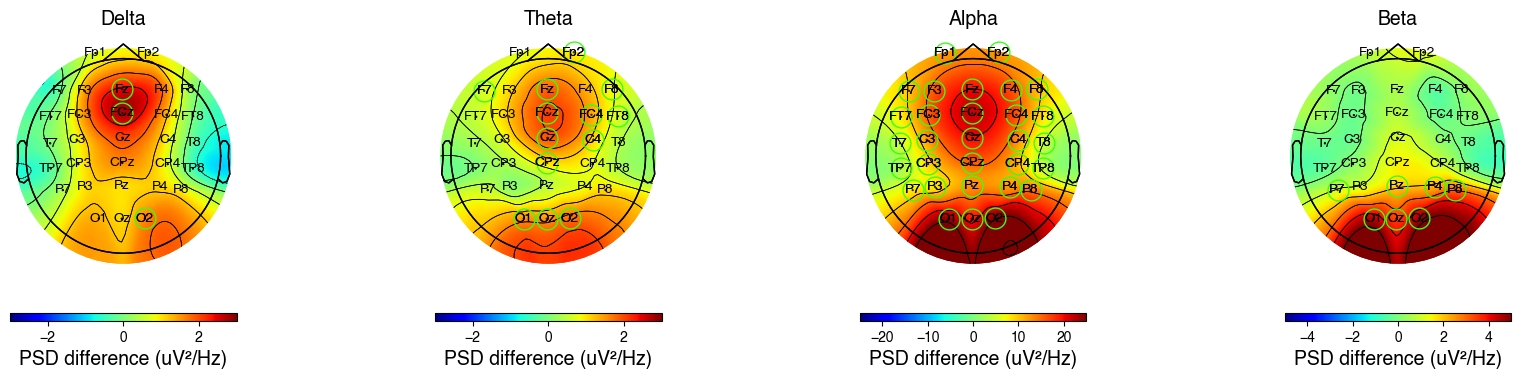

100%|██████████| 26/26 [00:33<00:00,  1.28s/it]


Grand PSD difference ['imagery_24', 'imagery_27', 'imagery_25', 'imagery_28', 'imagery_29', 'imagery_26'] - ['fixation_6']


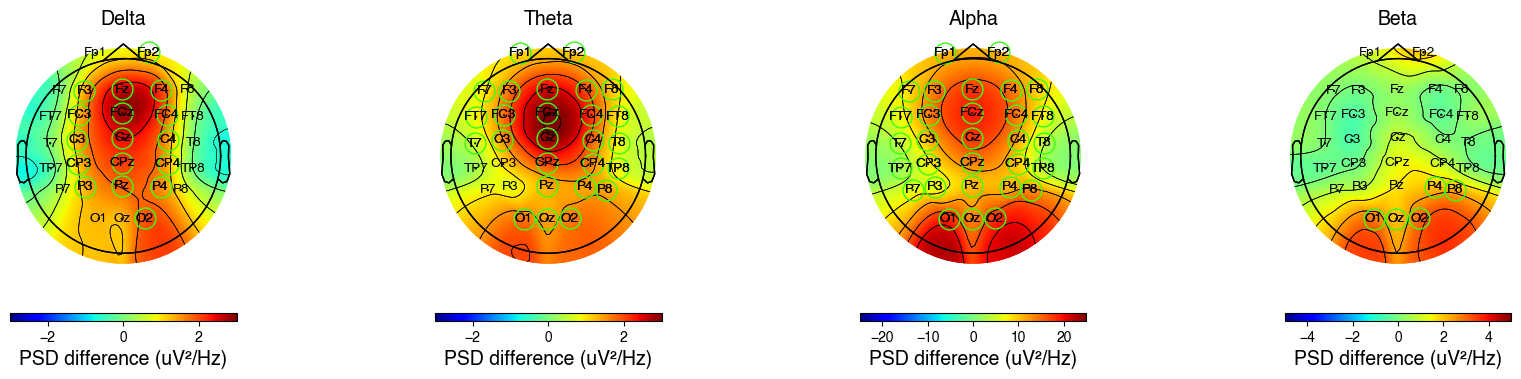

100%|██████████| 26/26 [00:37<00:00,  1.43s/it]


Grand PSD difference ['imagery_44', 'imagery_31', 'imagery_30', 'imagery_37', 'imagery_39', 'imagery_42', 'imagery_33', 'imagery_38', 'imagery_43', 'imagery_40', 'imagery_46', 'imagery_47', 'imagery_45', 'imagery_41', 'imagery_36', 'imagery_35', 'imagery_32', 'imagery_34'] - ['fixation_6']


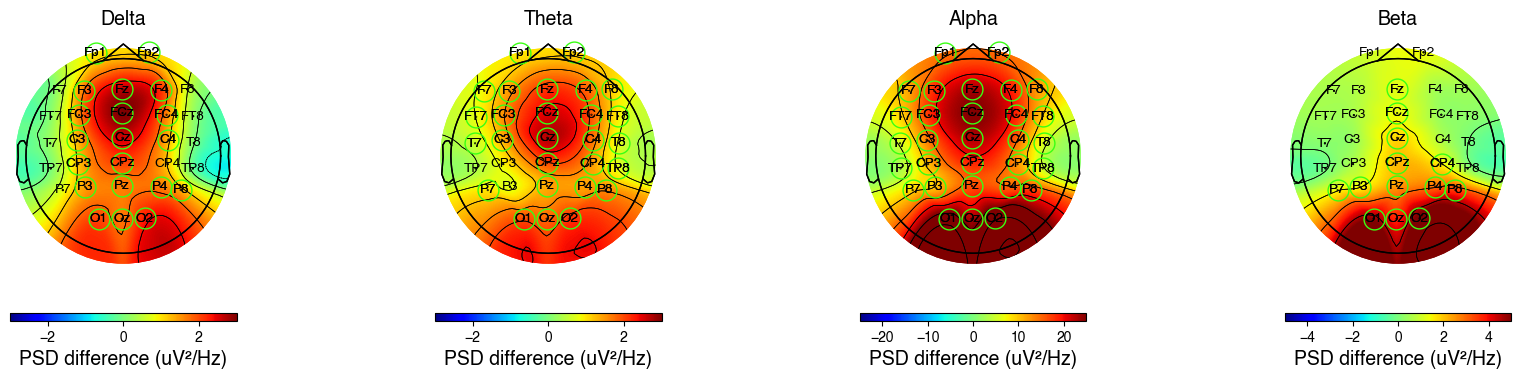

100%|██████████| 26/26 [00:48<00:00,  1.88s/it]


Grand PSD difference ['imagery_44', 'imagery_23', 'imagery_30', 'imagery_31', 'imagery_37', 'imagery_39', 'imagery_42', 'imagery_38', 'imagery_33', 'imagery_21', 'imagery_28', 'imagery_43', 'imagery_22', 'imagery_46', 'imagery_40', 'imagery_27', 'imagery_47', 'imagery_45', 'imagery_25', 'imagery_29', 'imagery_41', 'imagery_36', 'imagery_35', 'imagery_24', 'imagery_26', 'imagery_32', 'imagery_34'] - ['fixation_6']


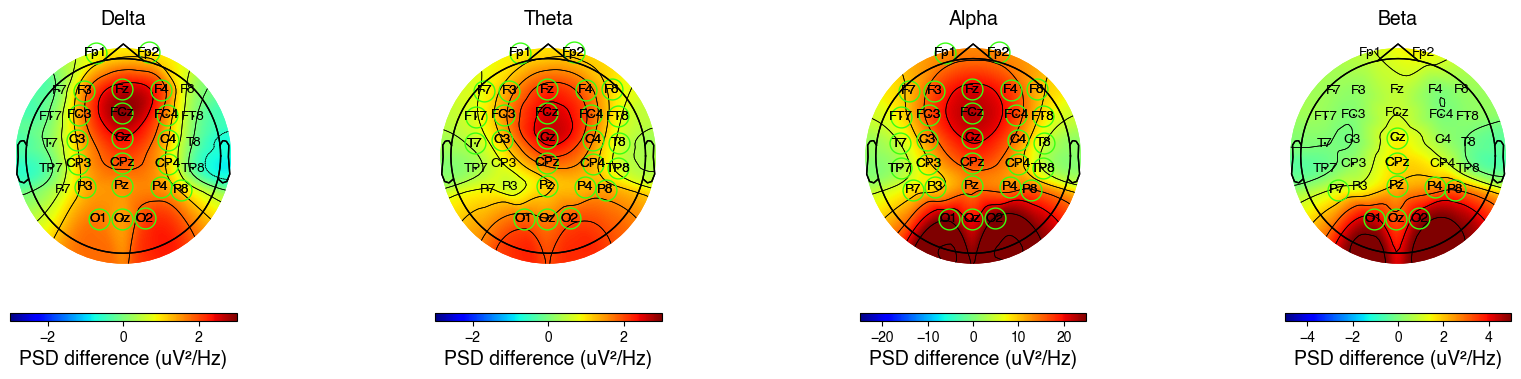

In [62]:
myVlims = [[-3, 3], [-3, 3], [-25, 25], [-5, 5]]
#visual
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_visual"], ["imagery_auditory"]), "task_epoch", "imagery", 
                  filt_trigger([], [], ["fixation_fixation"], []), "task_epoch", "fixation", test="wilcoxon", vlims=myVlims)
#auditor
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_auditory"], ["imagery_visual"]), "task_epoch", "imagery", 
                  filt_trigger([], [], ["fixation_fixation"], []), "task_epoch", "fixation", test="wilcoxon", vlims=myVlims)
#mix
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_mix"], []), "task_epoch", "imagery", 
                  filt_trigger([], [], ["fixation_fixation"], []), "task_epoch", "fixation", test="wilcoxon", vlims=myVlims)
#
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_visual", "imagery_auditory"], []), "task_epoch", "imagery", 
                  filt_trigger([], [], ["fixation_fixation"], []), "task_epoch", "fixation", test="wilcoxon", vlims=myVlims)
print()  # supresss return output

Imagery type difference

100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


Grand PSD difference ['imagery_23', 'imagery_21', 'imagery_22'] - ['imagery_24', 'imagery_27', 'imagery_25', 'imagery_28', 'imagery_29', 'imagery_26']


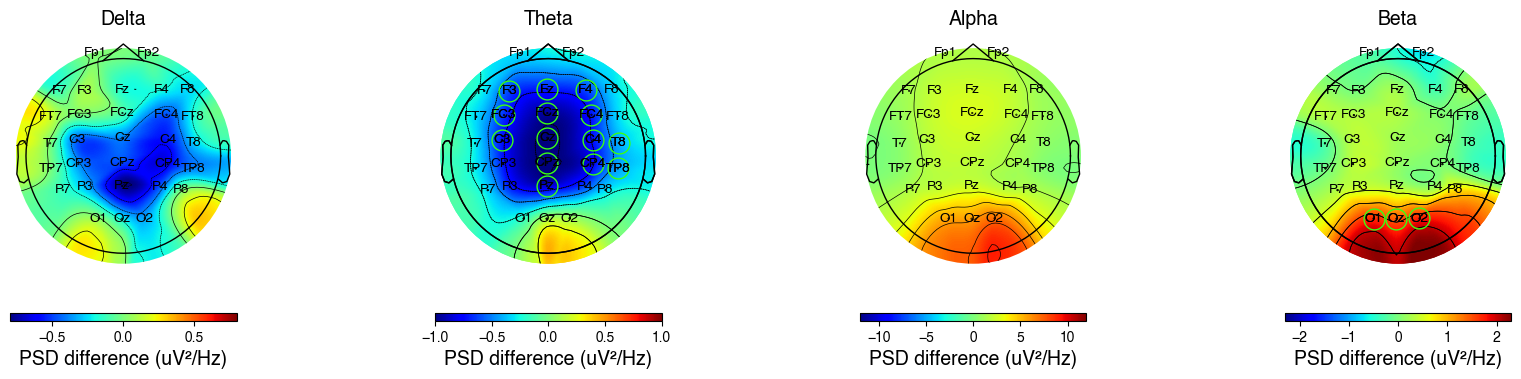

100%|██████████| 26/26 [00:20<00:00,  1.29it/s]


Grand PSD difference ['imagery_44', 'imagery_31', 'imagery_30', 'imagery_37', 'imagery_39', 'imagery_42', 'imagery_33', 'imagery_38', 'imagery_43', 'imagery_40', 'imagery_46', 'imagery_47', 'imagery_45', 'imagery_41', 'imagery_36', 'imagery_35', 'imagery_32', 'imagery_34'] - ['imagery_23', 'imagery_21', 'imagery_22']


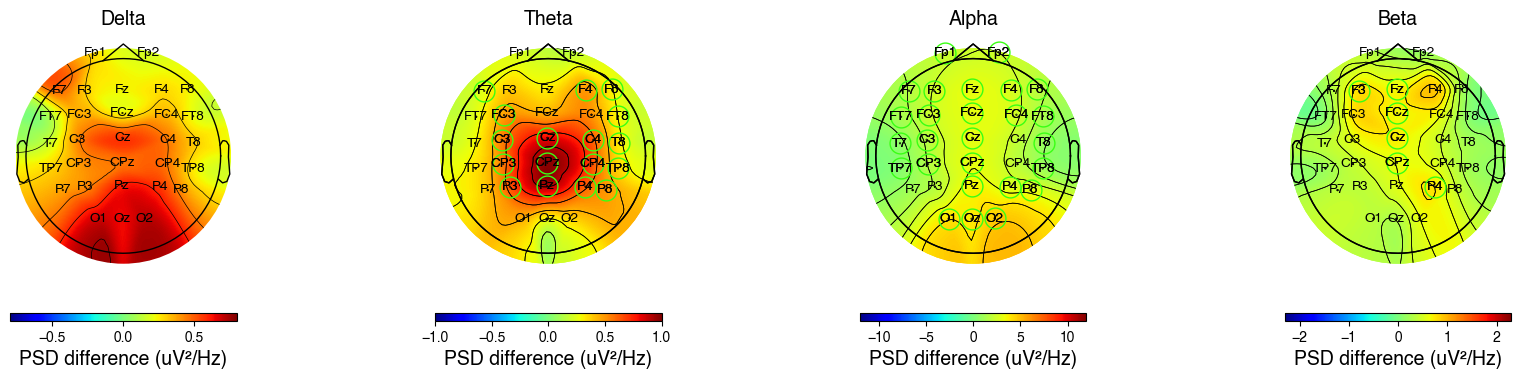

100%|██████████| 26/26 [00:21<00:00,  1.19it/s]


Grand PSD difference ['imagery_44', 'imagery_31', 'imagery_30', 'imagery_37', 'imagery_39', 'imagery_42', 'imagery_33', 'imagery_38', 'imagery_43', 'imagery_40', 'imagery_46', 'imagery_47', 'imagery_45', 'imagery_41', 'imagery_36', 'imagery_35', 'imagery_32', 'imagery_34'] - ['imagery_24', 'imagery_27', 'imagery_25', 'imagery_28', 'imagery_29', 'imagery_26']


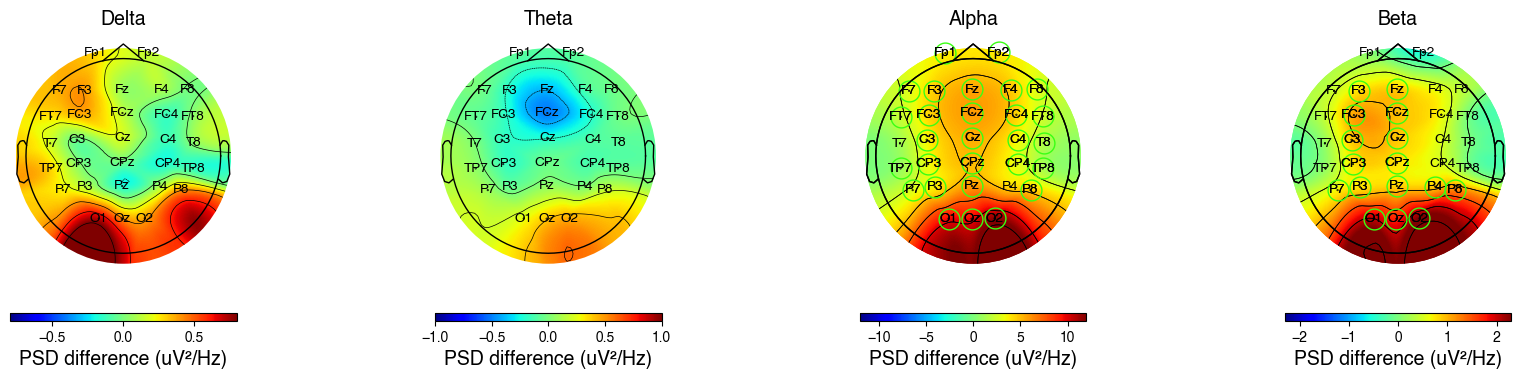

In [63]:
myVlims = [[-0.8, 0.8], [-1, 1], [-12, 12], [-2.3, 2.3]]
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_visual"], ["imagery_auditory"]), "task_epoch", "imagery", 
                  filt_trigger([], [], ["imagery_auditory"], ["imagery_visual"]), "task_epoch", "imagery", test="wilcoxon", vlims=myVlims)
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_mix"], []), "task_epoch", "imagery", 
                  filt_trigger([], [], ["imagery_visual"], ["imagery_auditory"]), "task_epoch", "imagery", test="wilcoxon", vlims=myVlims)
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_mix"], []), "task_epoch", "imagery", 
                  filt_trigger([], [], ["imagery_auditory"], ["imagery_visual"]), "task_epoch", "imagery", test="wilcoxon", vlims=myVlims)
print()  # supresss return output

Plot PSD difference topo accross subjects (fixation - resting)

In [ ]:
plotGrandDeltaPSD(filt_trigger([], [], ["fixation_fixation"], []), "task_epoch", "fixation",
                  filt_trigger([], [], ["resting_open"], []), "resting_epoch", "resting", test="wilcoxon")
print()  # supresss return output

Plot PSD difference topo accross subjects (imagery - resting)

100%|██████████| 26/26 [00:15<00:00,  1.66it/s]


Grand PSD difference ['imagery_23', 'imagery_21', 'imagery_22'] - ['resting_5']


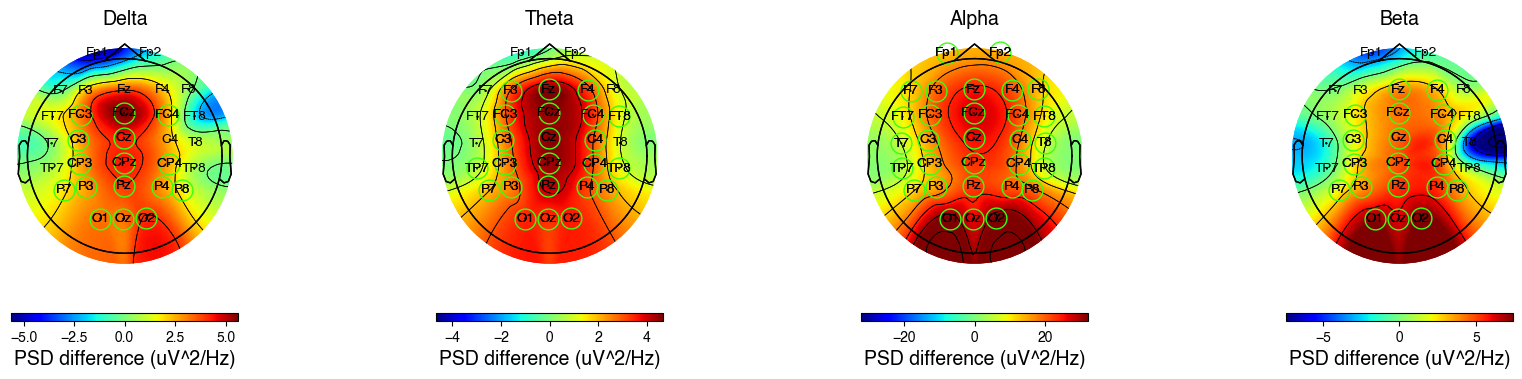

100%|██████████| 26/26 [00:14<00:00,  1.81it/s]


Grand PSD difference ['imagery_24', 'imagery_27', 'imagery_25', 'imagery_28', 'imagery_29', 'imagery_26'] - ['resting_5']


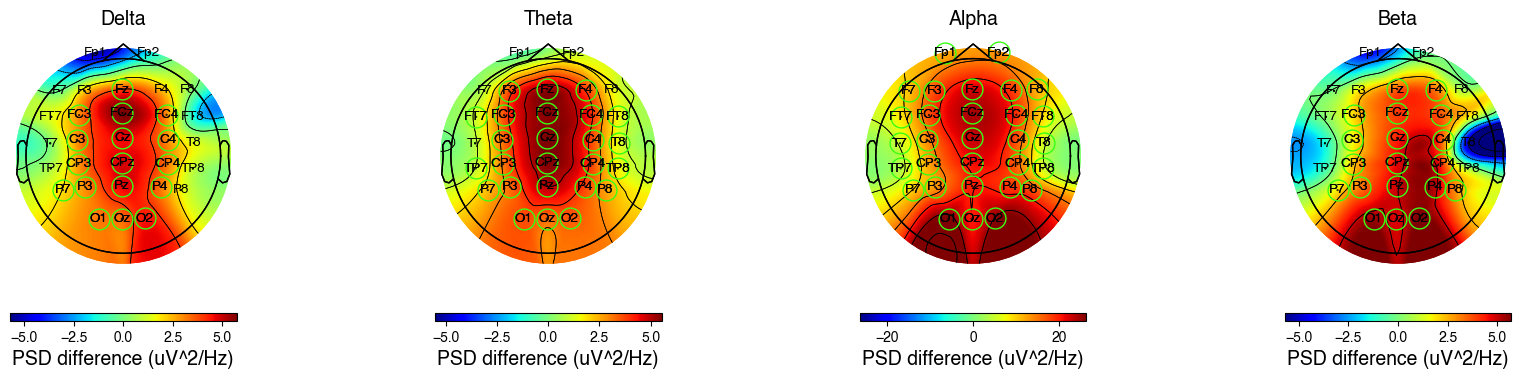

100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


Grand PSD difference ['imagery_44', 'imagery_31', 'imagery_30', 'imagery_37', 'imagery_39', 'imagery_42', 'imagery_33', 'imagery_38', 'imagery_43', 'imagery_40', 'imagery_46', 'imagery_47', 'imagery_45', 'imagery_41', 'imagery_36', 'imagery_35', 'imagery_32', 'imagery_34'] - ['resting_5']


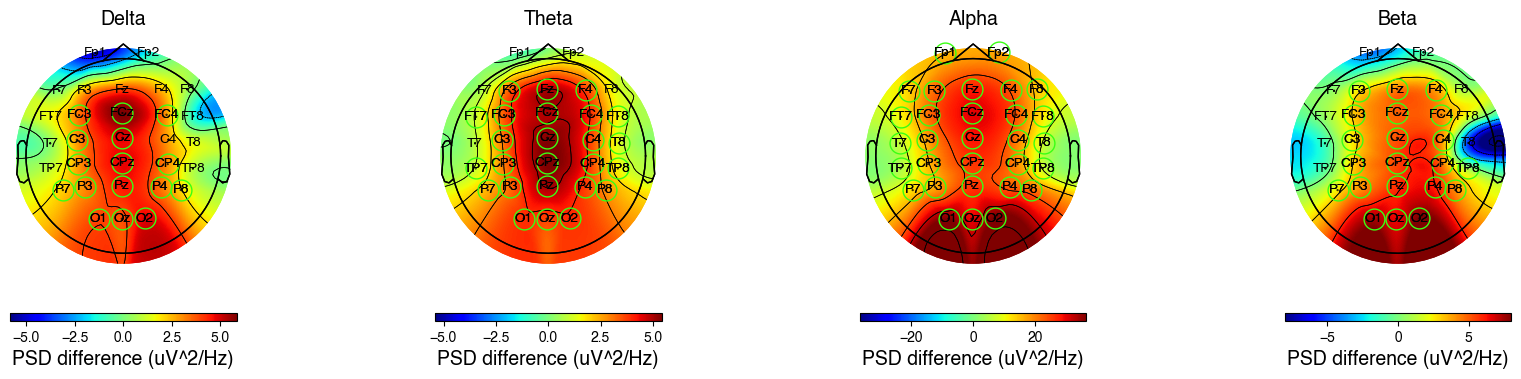

100%|██████████| 26/26 [00:23<00:00,  1.11it/s]


Grand PSD difference ['imagery_44', 'imagery_23', 'imagery_30', 'imagery_31', 'imagery_37', 'imagery_39', 'imagery_42', 'imagery_38', 'imagery_33', 'imagery_21', 'imagery_28', 'imagery_43', 'imagery_22', 'imagery_46', 'imagery_40', 'imagery_27', 'imagery_47', 'imagery_45', 'imagery_25', 'imagery_29', 'imagery_41', 'imagery_36', 'imagery_35', 'imagery_24', 'imagery_26', 'imagery_32', 'imagery_34'] - ['resting_5']


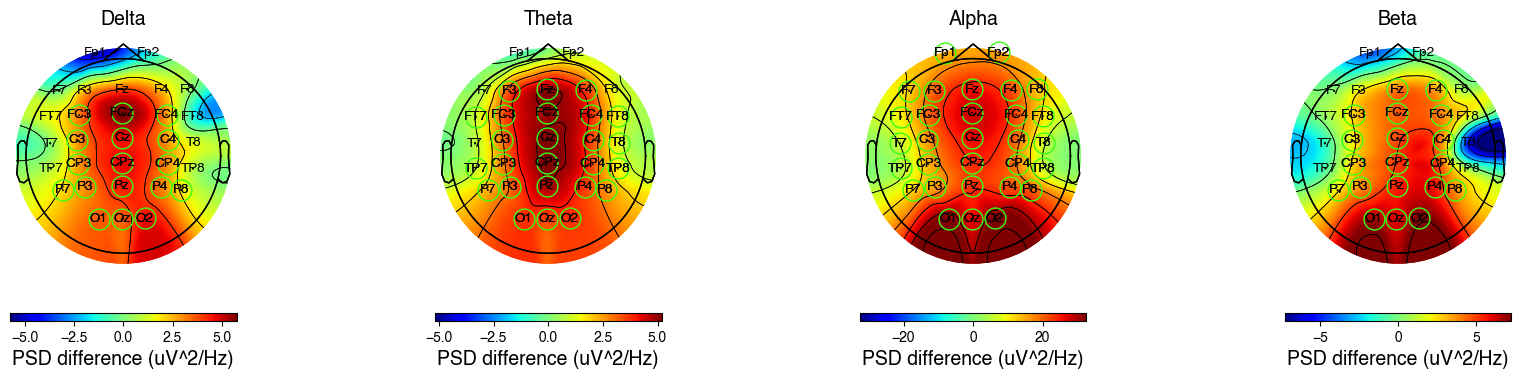

In [56]:
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_visual"], ["imagery_auditory"]), "task_epoch", "imagery", 
                  filt_trigger([], [], ["resting_open"], []), "resting_epoch", "resting", test="wilcoxon")
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_auditory"], ["imagery_visual"]), "task_epoch", "imagery", 
                  filt_trigger([], [], ["resting_open"], []), "resting_epoch", "resting", test="wilcoxon")
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_mix"], []), "task_epoch", "imagery", 
                  filt_trigger([], [], ["resting_open"], []), "resting_epoch", "resting", test="wilcoxon")
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_visual", "imagery_auditory"], []), "task_epoch", "imagery", 
                  filt_trigger([], [], ["resting_open"], []), "resting_epoch", "resting", test="wilcoxon")
print()  # supresss return output

fixation PSD

100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


Grand PSD ['fixation_6']


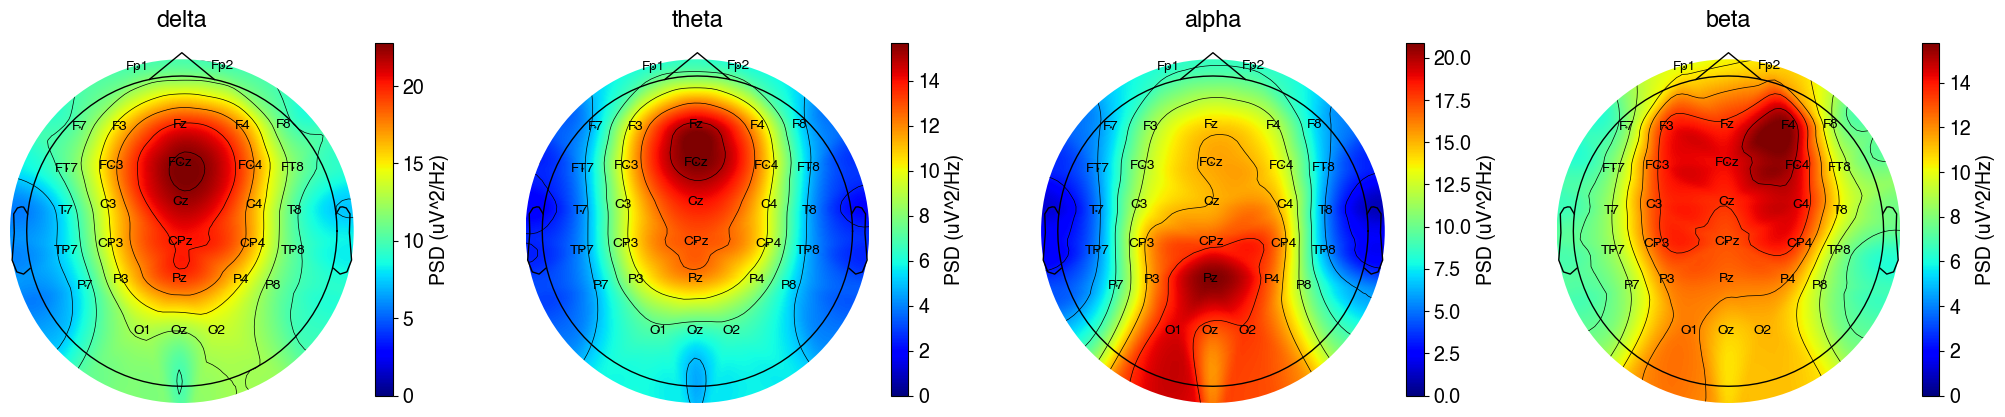

In [54]:
plotGrandPSD(filt_trigger([], [], ["fixation_fixation"], []), "task_epoch", "fixation")

Resting PSD

100%|██████████| 26/26 [00:01<00:00, 24.40it/s]


Grand PSD ['resting_5']


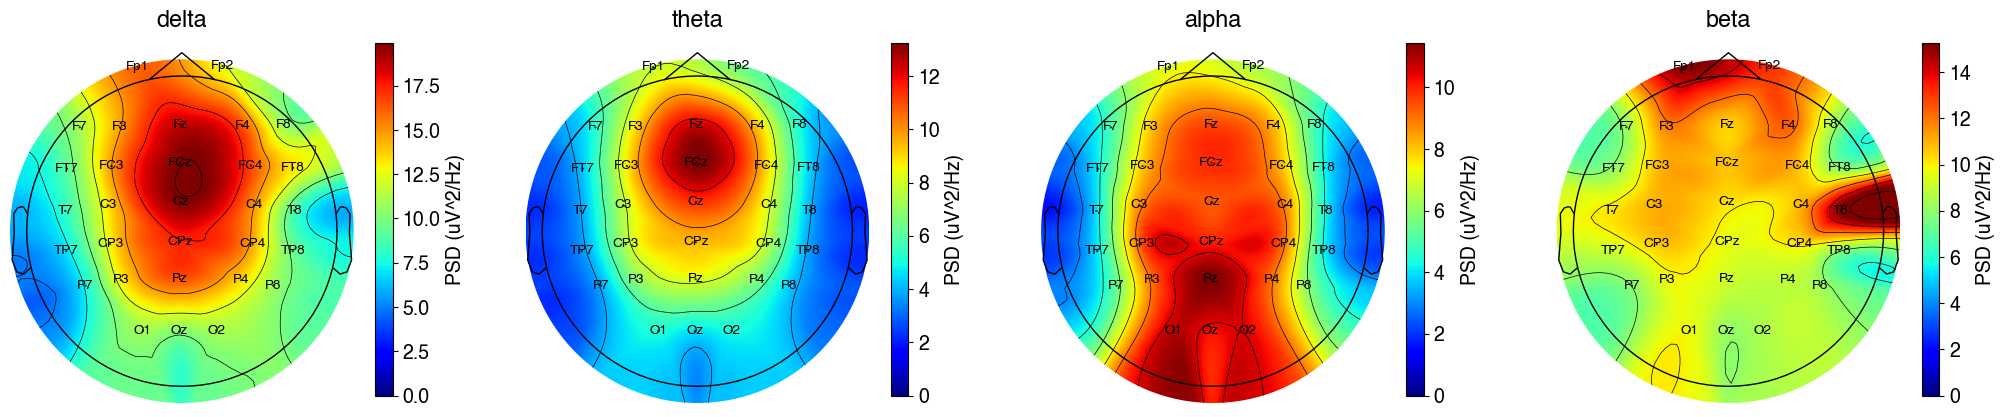

100%|██████████| 26/26 [00:00<00:00, 43.51it/s]


Grand PSD ['resting_3']


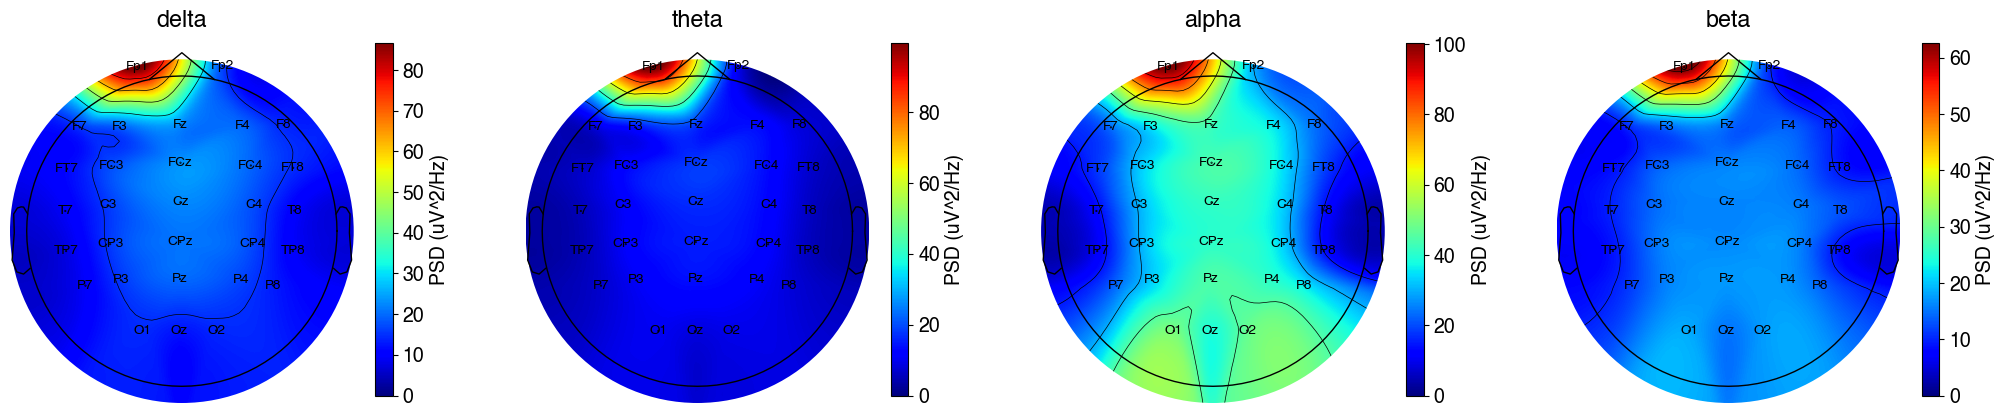

In [55]:
plotGrandPSD(filt_trigger([], [], ["resting_open"], []), "resting_epoch", "resting")
plotGrandPSD(filt_trigger([], [], ["resting_close"], []), "resting_epoch", "resting")
print()  # supresss return output

face V.S. non-face imagery

100%|██████████| 26/26 [00:24<00:00,  1.05it/s]


Grand PSD difference ['imagery_44', 'imagery_37', 'imagery_42', 'imagery_45', 'imagery_39', 'imagery_38', 'imagery_21', 'imagery_43', 'imagery_41', 'imagery_22', 'imagery_36', 'imagery_40', 'imagery_46', 'imagery_47'] - ['imagery_23', 'imagery_30', 'imagery_31', 'imagery_33', 'imagery_25', 'imagery_28', 'imagery_29', 'imagery_35', 'imagery_24', 'imagery_27', 'imagery_26', 'imagery_32', 'imagery_34']


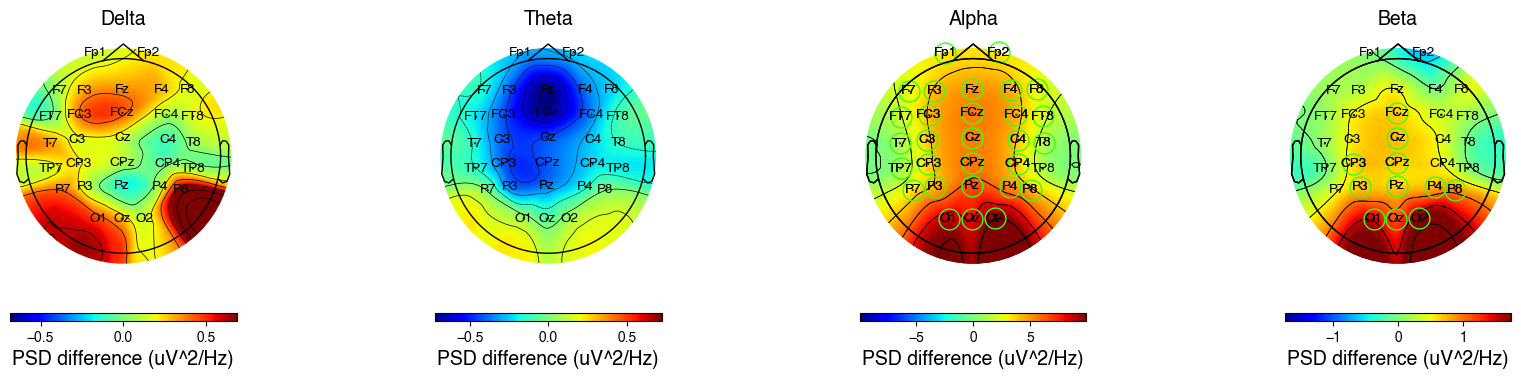

In [58]:
plotGrandDeltaPSD(filt_trigger([], [], ["imagery_face"], []), "task_epoch", "imagery",
                  filt_trigger([], [], ["imagery_auditory", "imagery_visual"], ["imagery_face"]), "task_epoch", "imagery", test="wilcoxon")
print()  # supresss return output


PSD - fixation (per trigger)

100%|██████████| 26/26 [00:32<00:00,  1.27s/it]


Grand PSD difference ['imagery_21'] - ['fixation_6']


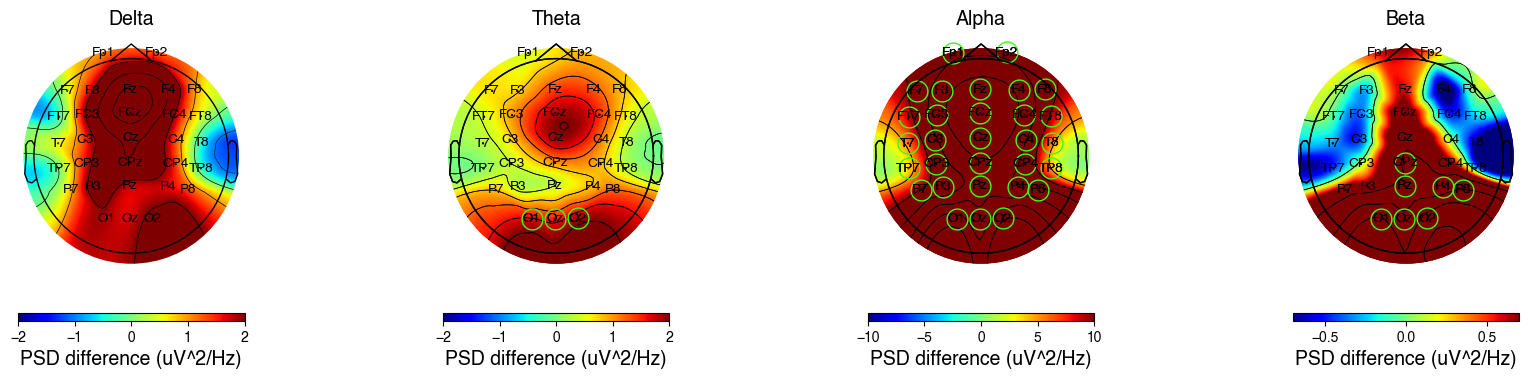

trigger: 21


100%|██████████| 26/26 [00:29<00:00,  1.13s/it]


Grand PSD difference ['imagery_22'] - ['fixation_6']


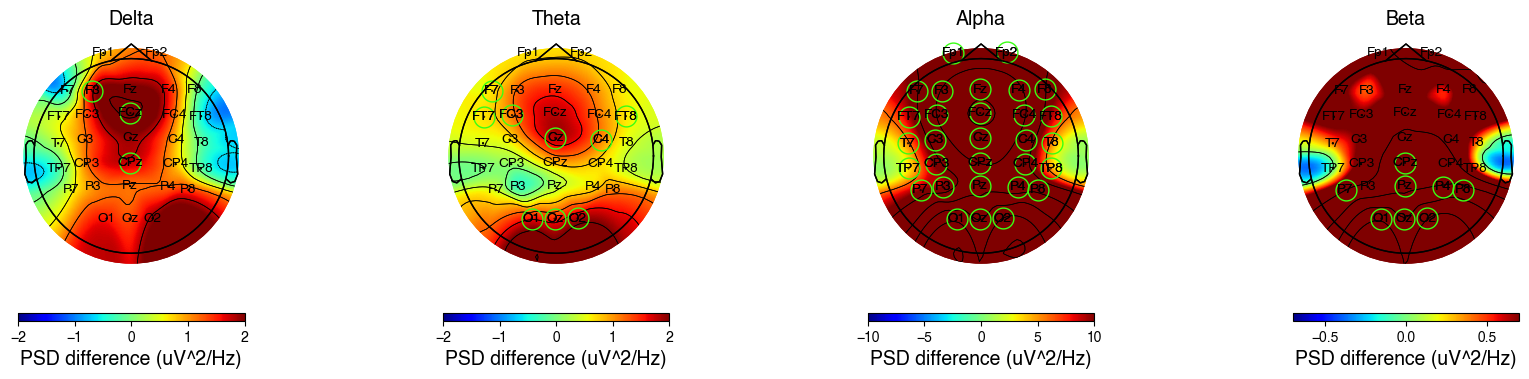

trigger: 22


100%|██████████| 26/26 [00:33<00:00,  1.29s/it]


Grand PSD difference ['imagery_23'] - ['fixation_6']


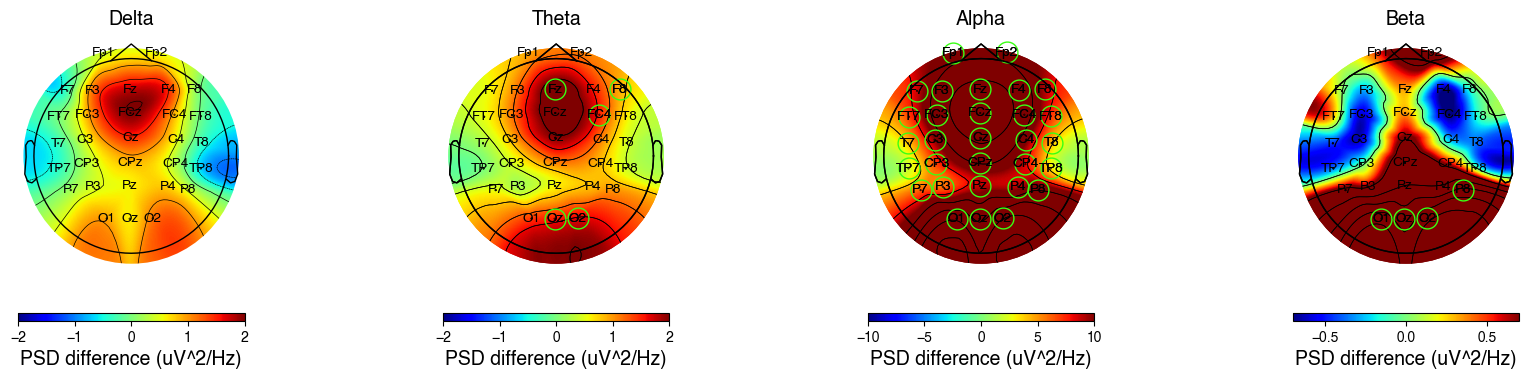

trigger: 23


100%|██████████| 26/26 [00:27<00:00,  1.04s/it]


Grand PSD difference ['imagery_24'] - ['fixation_6']


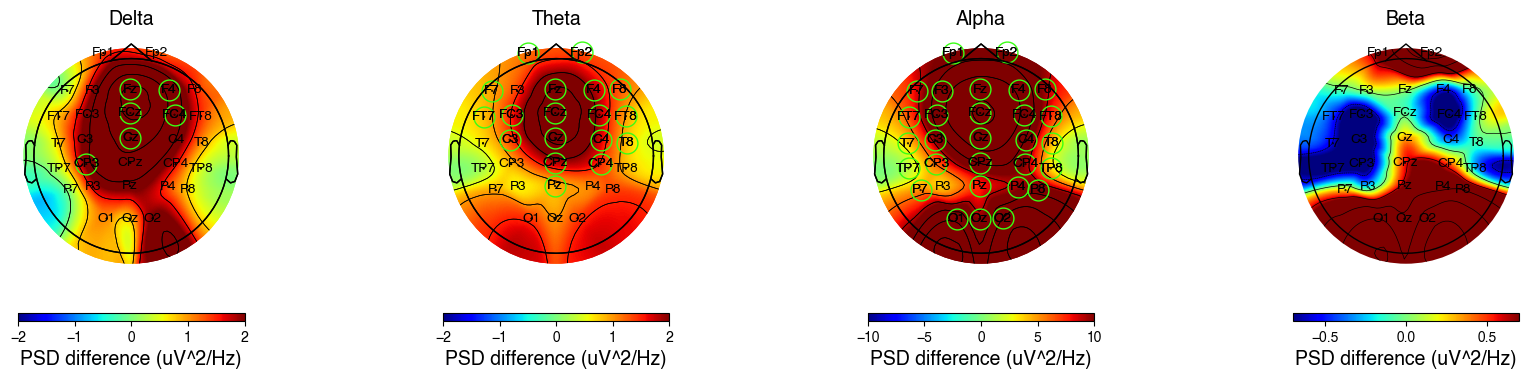

trigger: 24


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


Grand PSD difference ['imagery_25'] - ['fixation_6']


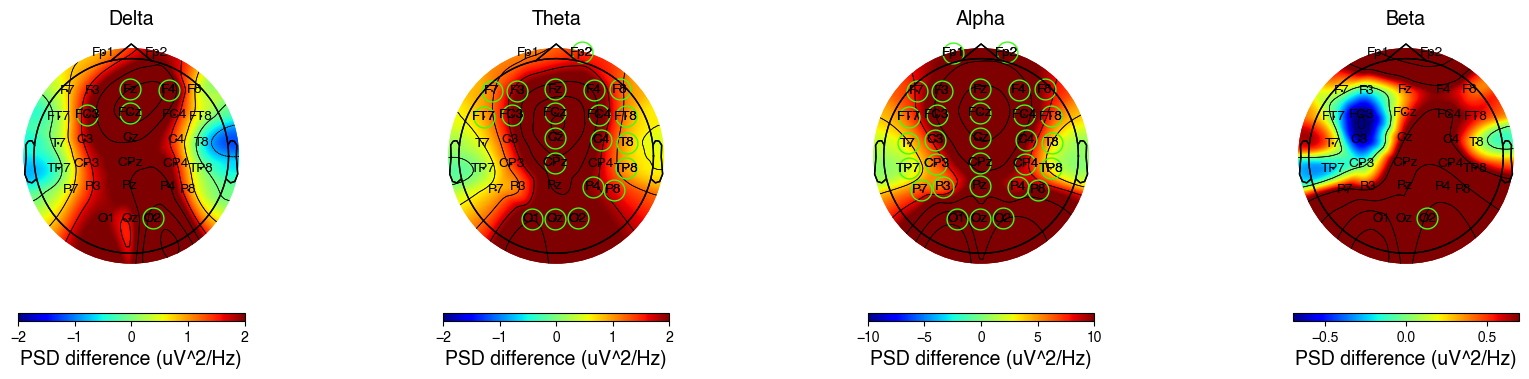

trigger: 25


100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Grand PSD difference ['imagery_26'] - ['fixation_6']


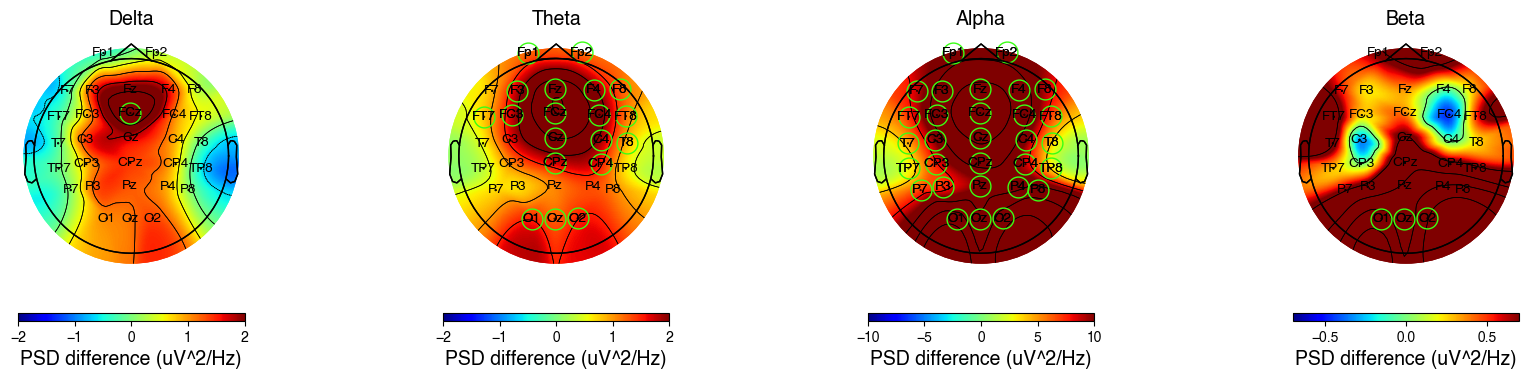

trigger: 26


100%|██████████| 26/26 [00:25<00:00,  1.01it/s]


Grand PSD difference ['imagery_27'] - ['fixation_6']


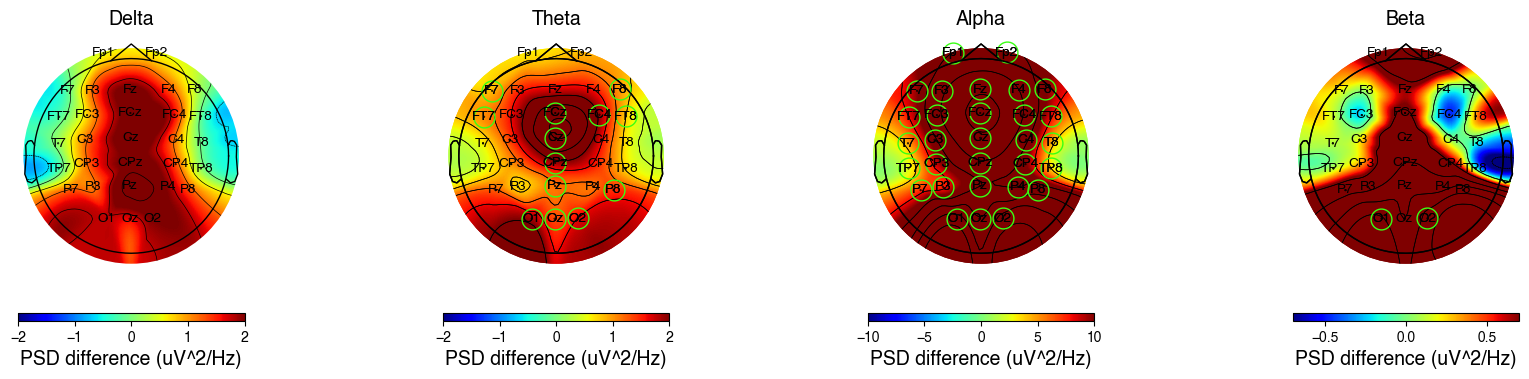

trigger: 27


100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


Grand PSD difference ['imagery_28'] - ['fixation_6']


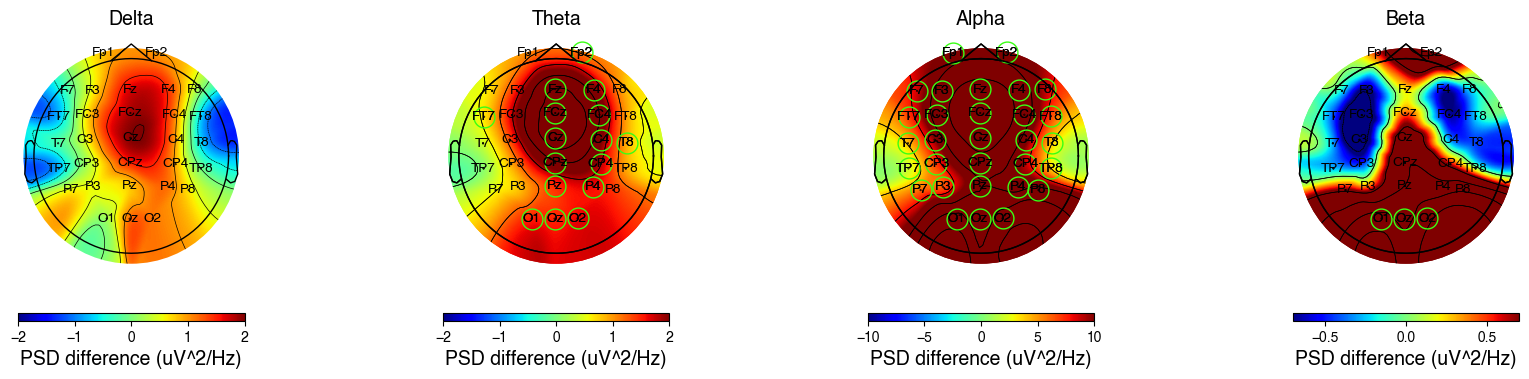

trigger: 28


100%|██████████| 26/26 [00:24<00:00,  1.05it/s]


Grand PSD difference ['imagery_29'] - ['fixation_6']


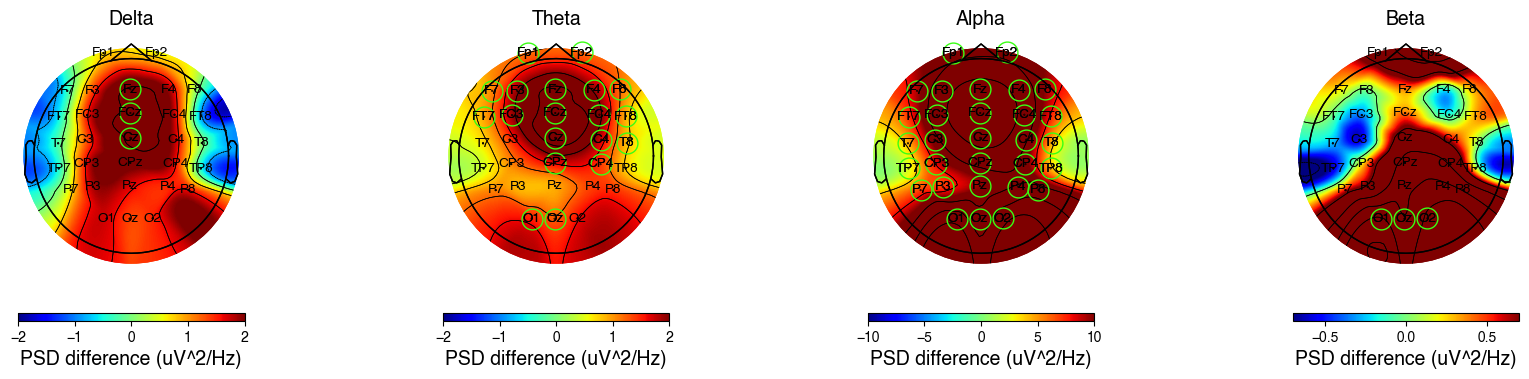

trigger: 29


100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


Grand PSD difference ['imagery_30'] - ['fixation_6']


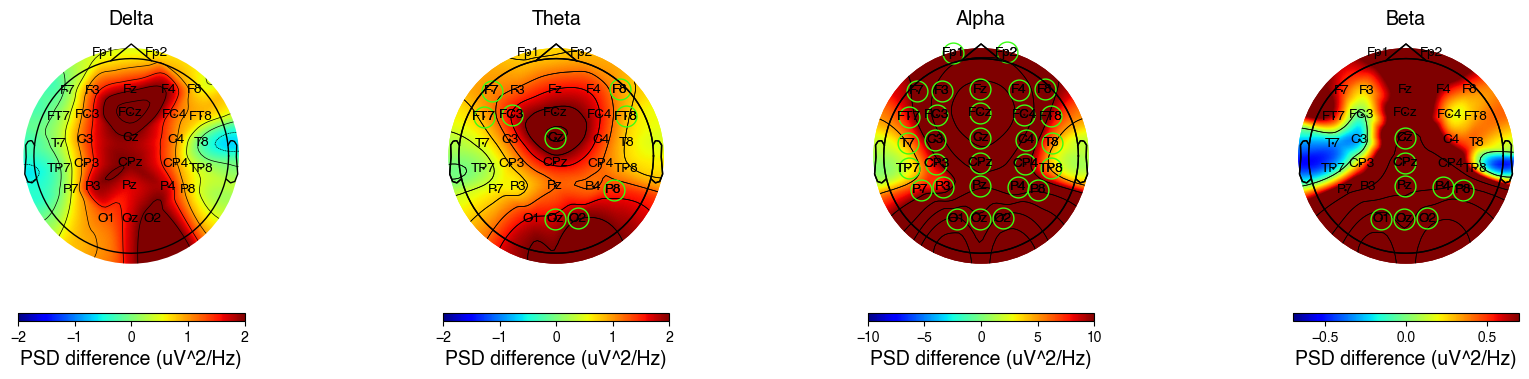

trigger: 30


100%|██████████| 26/26 [00:27<00:00,  1.07s/it]


Grand PSD difference ['imagery_31'] - ['fixation_6']


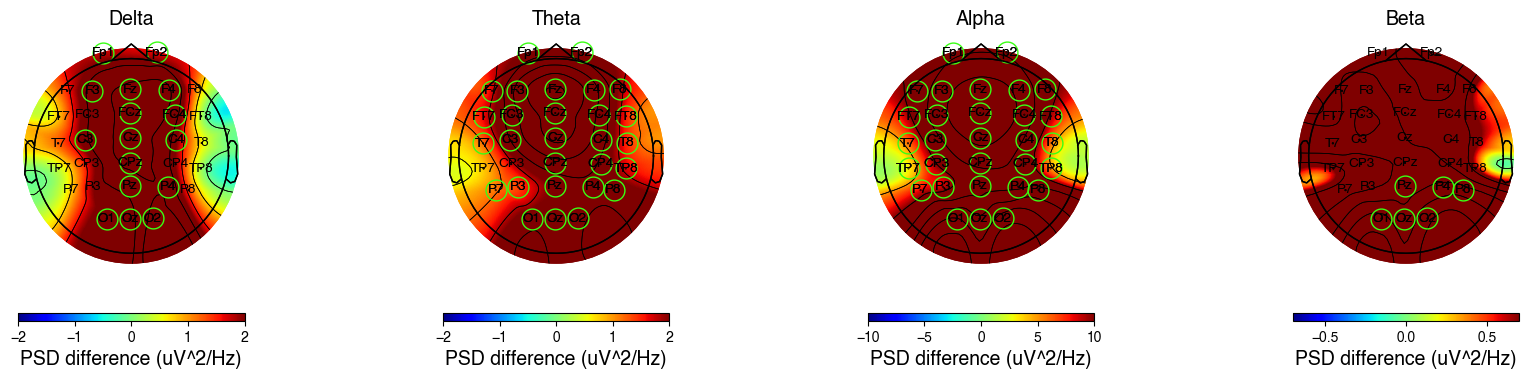

trigger: 31


100%|██████████| 26/26 [00:34<00:00,  1.32s/it]


Grand PSD difference ['imagery_32'] - ['fixation_6']


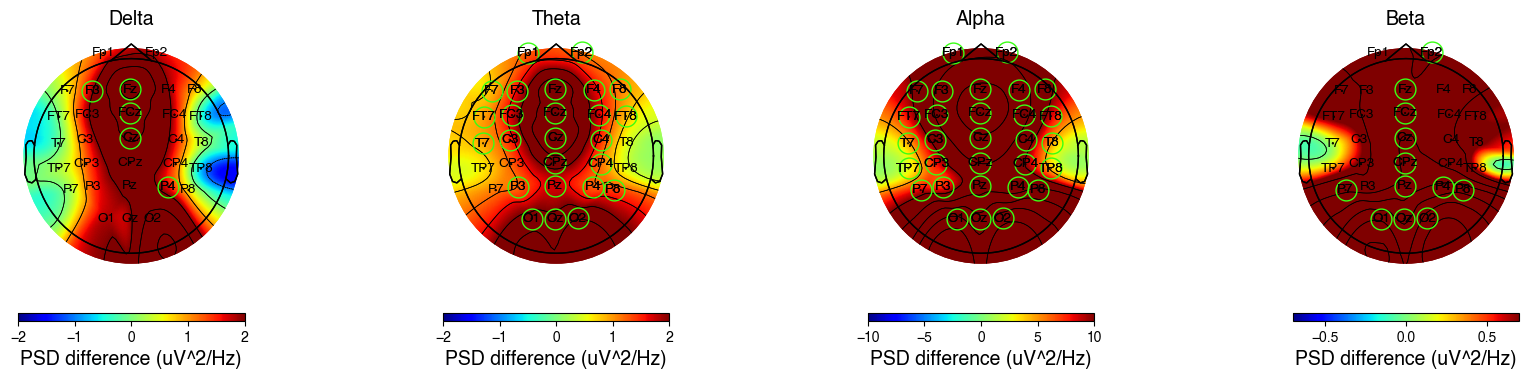

trigger: 32


100%|██████████| 26/26 [00:31<00:00,  1.21s/it]


Grand PSD difference ['imagery_33'] - ['fixation_6']


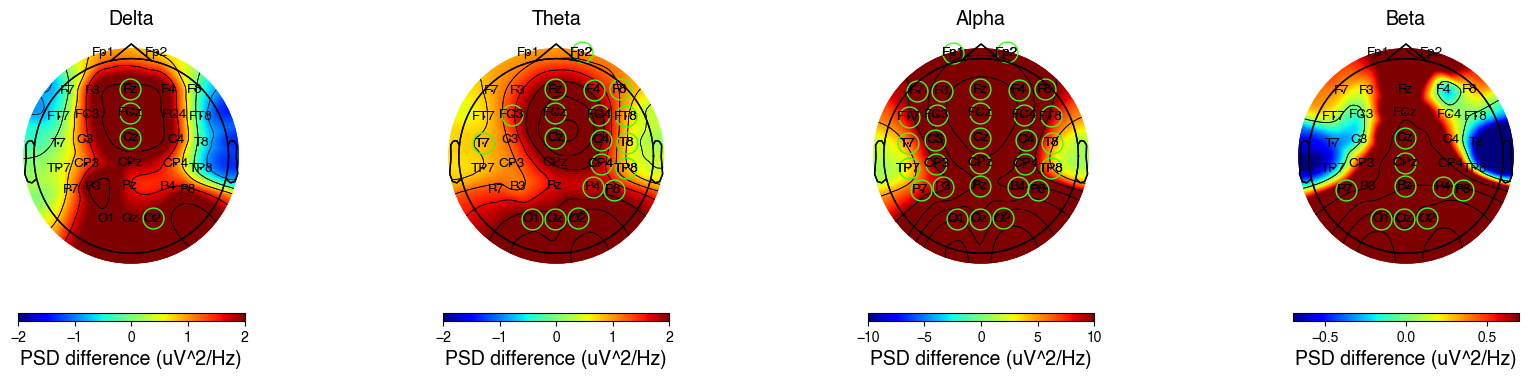

trigger: 33


100%|██████████| 26/26 [00:32<00:00,  1.26s/it]


Grand PSD difference ['imagery_34'] - ['fixation_6']


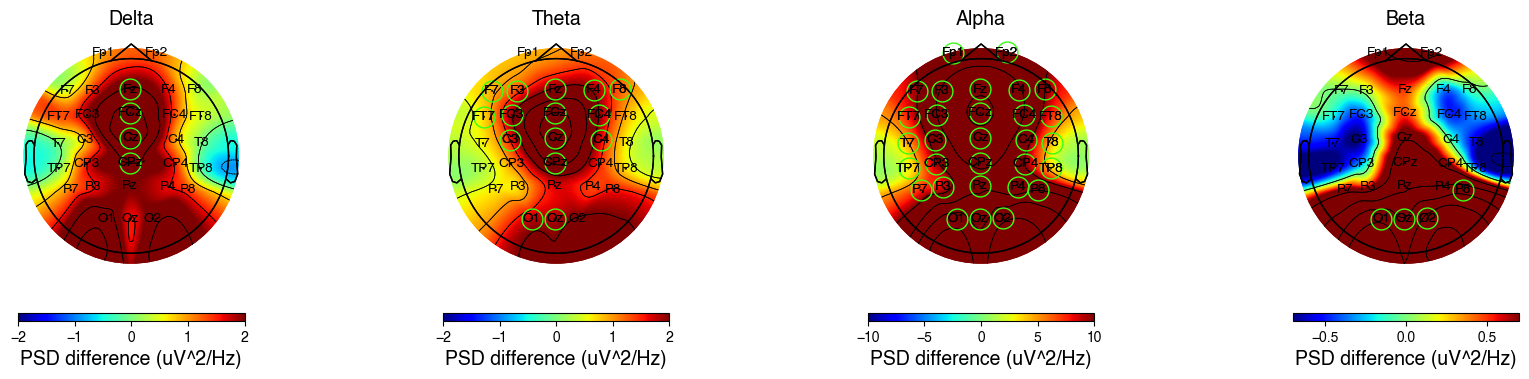

trigger: 34


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


Grand PSD difference ['imagery_35'] - ['fixation_6']


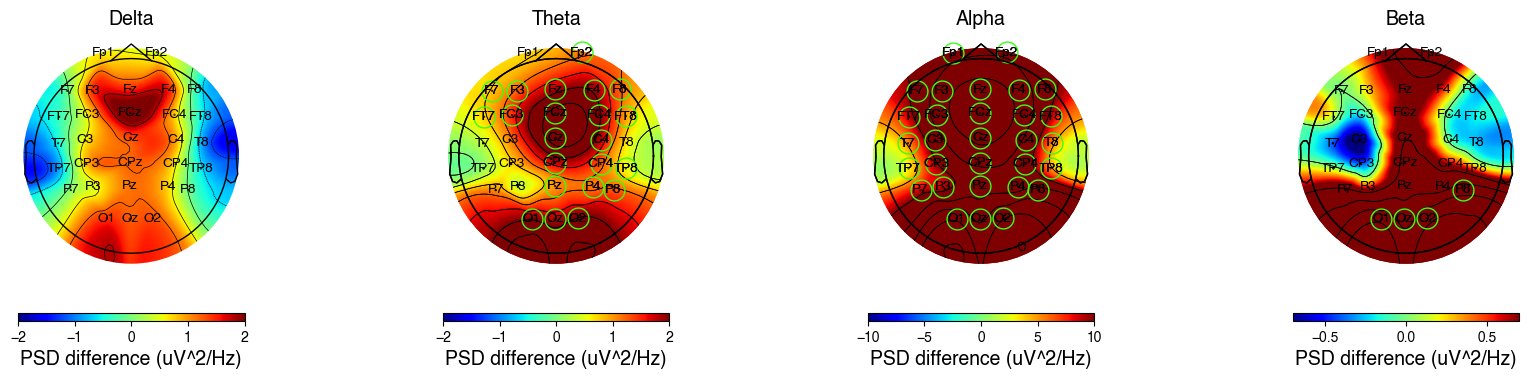

trigger: 35


100%|██████████| 26/26 [00:30<00:00,  1.17s/it]


Grand PSD difference ['imagery_36'] - ['fixation_6']


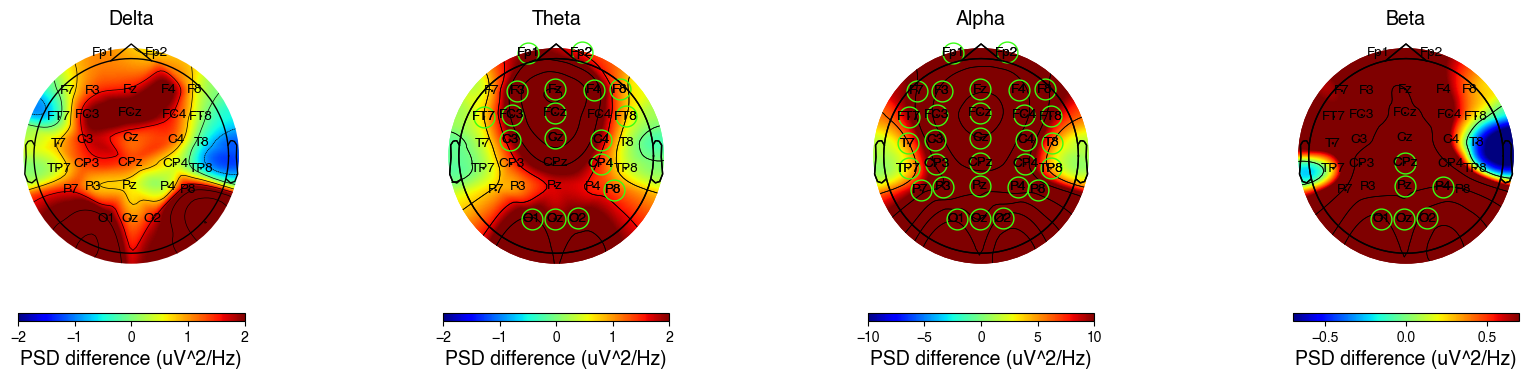

trigger: 36


100%|██████████| 26/26 [00:28<00:00,  1.08s/it]


Grand PSD difference ['imagery_37'] - ['fixation_6']


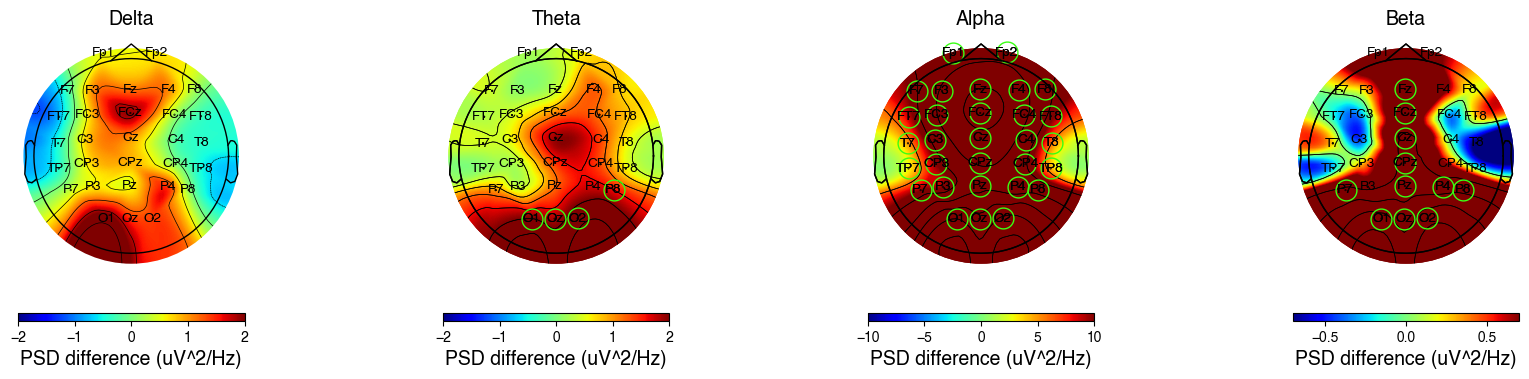

trigger: 37


100%|██████████| 26/26 [00:30<00:00,  1.19s/it]


Grand PSD difference ['imagery_38'] - ['fixation_6']


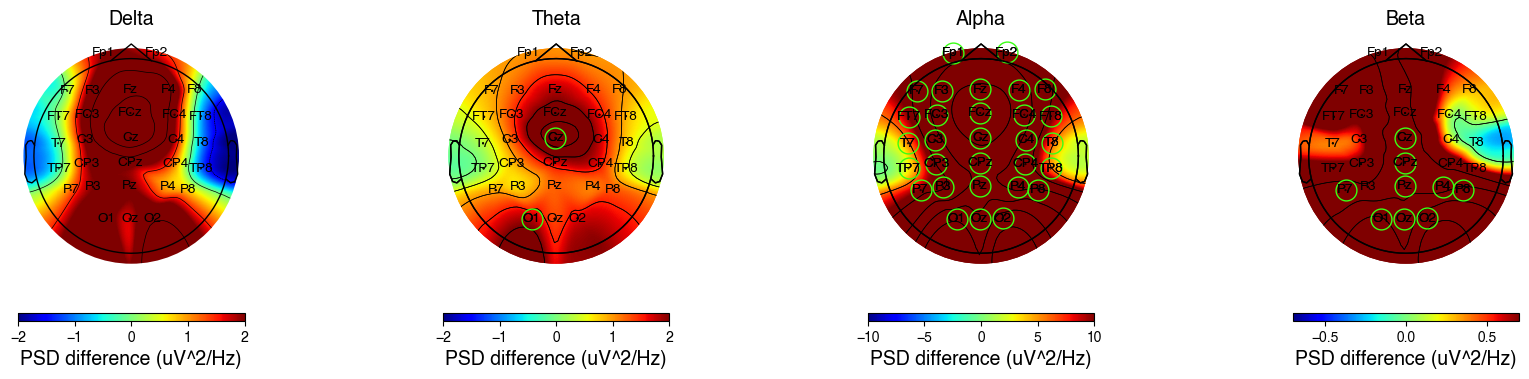

trigger: 38


100%|██████████| 26/26 [00:29<00:00,  1.12s/it]


Grand PSD difference ['imagery_39'] - ['fixation_6']


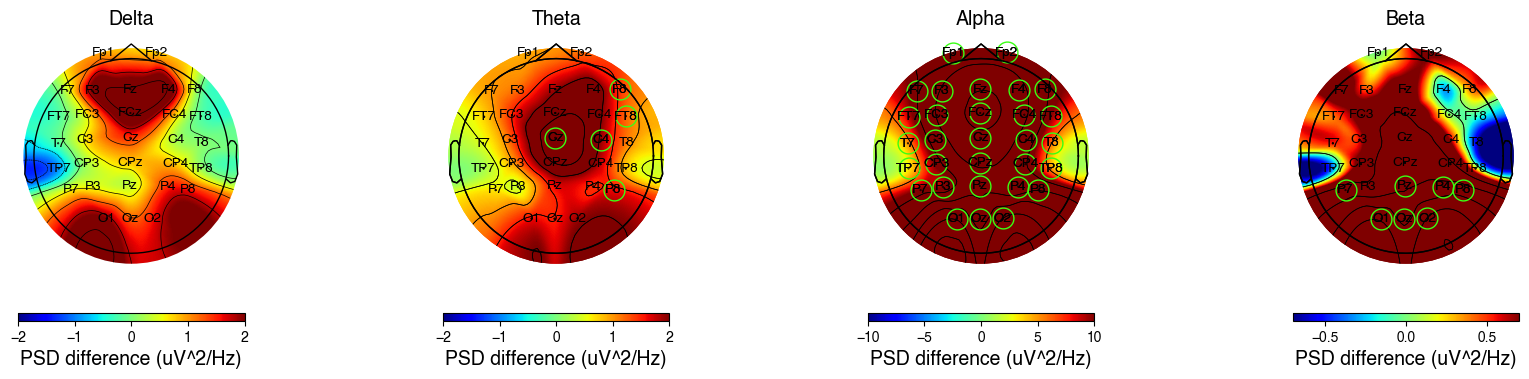

trigger: 39


 62%|██████▏   | 16/26 [00:19<00:12,  1.21s/it]


KeyboardInterrupt: 

In [59]:
for t in range(21, 48):
    plotGrandDeltaPSD(filt_trigger([f"imagery_{t}"], [], [], []), "task_epoch", "imagery",
                      filt_trigger([], [], ["fixation_fixation"], []), "task_epoch", "fixation", test="wilcoxon", vlims=[[-2, 2], [-2, 2], [-10, 10], [-0.7, 0.7]])
    print(f"trigger: {t}")